In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#import data
from google.colab import files 
uploaded = files.upload()

Saving features_and_target_cat_to_num.csv to features_and_target_cat_to_num.csv


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['features_and_target_cat_to_num.csv']))

In [ ]:
#add a meta feature

#df['diag_minus_onset'] = df['diag_delta'] - df['onset_delta']

In [5]:
df = df.drop(columns='Unnamed: 0')

In [ ]:
#df = df.replace({'Gender':{"F":0, "M":1}})

### Selecting Features

In [6]:
feature_list = ['Age', 'Gender', 'diag_minus_onset', 'alsfrs_total_slope', 'mean_alsfrs_total', 'mean_alsfrs_hands','mean_alsfrs_respiratory', 'mean_alsfrs_leg', 'fvc_slope', 'fvc_mean', 'ALSFRS_slope']

In [7]:
df = df[feature_list]

In [8]:
df1 = df.copy()

In [9]:
y = df1[['ALSFRS_slope']]

In [10]:
X = df1.drop(columns='ALSFRS_slope')

### Train/Test split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=11)
# Setting seed : for reproducibility

### Creating new target: 'Progressor'

In [13]:
# Check median value (50%) of target variable

y_train.describe()

,ALSFRS_slope
count,2476.000000
mean,-0.719563
std,0.593514
min,-3.624784
25%,-1.077968
50%,-0.633681
75%,-0.296266
max,1.207011


In [14]:
# Create new column in Boolean

y_train["Progressor"] = y_train["ALSFRS_slope"] >= -0.633681
y_test["Progressor"] = y_test["ALSFRS_slope"] >= -0.633681

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
# Rename boolean values as 'slow' or 'rapid'

y_train = y_train.replace({'Progressor':{True:'slow', False:'rapid'}})
y_test = y_test.replace({'Progressor':{True:'slow', False:'rapid'}})
y_train2 = y_train[['Progressor']]
y_test2 = y_test[['Progressor']]

### Prediction

In [16]:
# Create a LogisticRegression object

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1000.0, random_state=0)
logreg.fit(X_train, y_train2)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

       rapid       0.57      0.57      0.57       306
        slow       0.58      0.59      0.59       314

    accuracy                           0.58       620
   macro avg       0.58      0.58      0.58       620
weighted avg       0.58      0.58      0.58       620



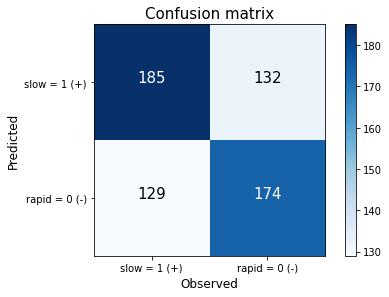

In [18]:
# Plot a confusion matrix & Print Classification report

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(cm, classes,normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0, fontsize = 10)
    plt.yticks(tick_marks, classes, fontsize = 10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 fontsize = 15,
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Predicted', fontsize = 12)
    plt.xlabel('Observed', fontsize = 12)

# Compute confusion matrix

cnf_matrix = confusion_matrix(y_pred, y_test2, labels = ['slow','rapid'])
np.set_printoptions(precision = 2)

# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['slow = 1 (+)','rapid = 0 (-)'], normalize = False,  title = 'Confusion matrix')

print(classification_report(y_test2, y_pred))

In [ ]:
# Calculate accuracy

from sklearn.metrics import accuracy_score

print(" Model accuracy: %.2f" %accuracy_score(y_test2, y_pred))

 Model accuracy: 0.58


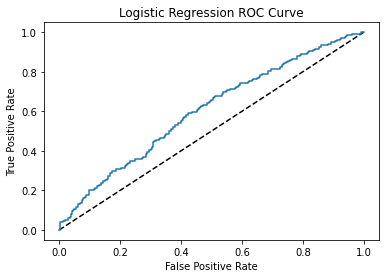

In [23]:
#Plotting the ROC curve

from sklearn.metrics import roc_curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test2, y_pred_prob, pos_label='slow')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

In [32]:
#Calculate AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test2, y_pred_prob)

0.6014945256234129

##Reapted 5-fold CV 

###1.Accuary

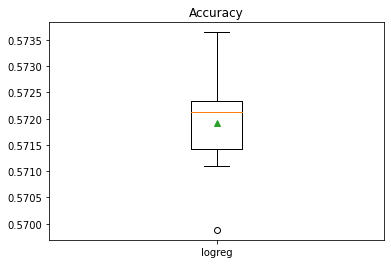

In [36]:
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
 
# evaluate a model_accuracy with a given number of repeats
def evaluate_model_accuracy(X, y, repeats):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=5, n_repeats=repeats, random_state=1)
	# create model
	model = LogisticRegression()
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# configurations to test
repeats = range(1,11)
results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model_accuracy(X_train, y_train2, r)
	# summarize
	# print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
	# store
	results.append(mean(scores))
# plot the results
pyplot.boxplot(results, labels=['logreg'], showmeans=True)
pyplot.title('Accuracy')
pyplot.show()

##2.AUC

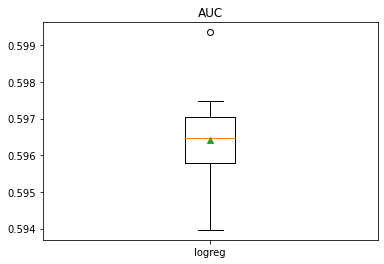

In [37]:
# evaluate a model_AUC with a given number of repeats
def evaluate_model_AUC(X, y, repeats):
	# prepare the cross-validation procedure
	cv = RepeatedKFold(n_splits=5, n_repeats=repeats, random_state=1)
	# create model
	model = LogisticRegression()
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	return scores
 
# configurations to test
repeats = range(1,11)
results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model_AUC(X_train, y_train2, r)
	# summarize
	# print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
	# store
	results.append(mean(scores))
# plot the results
pyplot.boxplot(results, labels=['logreg'], showmeans=True)
pyplot.title('AUC')
pyplot.show()